In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
# import cupy as cp

from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from cuml.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# error rate
def error_rate(x, opts):
    # parameters

    fold  = opts['fold']
    X   = fold['X'] 
    y    = fold['y']
    
    cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)

    # Klasifikasi tanpa optimasi
    mdl       = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C=x[0], gamma=x[1]))
    acc       = cross_val_score(mdl, X, y, cv=cv, scoring='accuracy')

    error = 1-np.mean(acc) 
    
    return error


# Error rate & Feature size
def Fun(x, opts):
    # Get error rate
    error = error_rate(x, opts)
    
    return error

In [4]:
import numpy as np
from numpy.random import rand
# from FS.functionHO import Fun

# inisialisasi posisi
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

# inisialisasi velocity
def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    
# fungsi utama dari PSO
def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 20
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension / parameter yang di optimasi
    dim = 2
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre / inisialisasi nilai  pbest (nilai gamma dan C) dan gbest (eror)
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf') # eror yang baru
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float') # eror sebelumnya
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        # Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness /hitung nilai eror kemudian bandingkan dengan eror sebelumnya
        for i in range(N):
            fit[i,0] = Fun(X[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1
        
        for i in range(N):
            for d in range(dim):
                
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
    # simpan nilai C dan gamma yang terbaik
    pso_data = {'param': Xgb, 'c': curve}
    
    return pso_data    

In [5]:
import numpy as np
import pandas as pd
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# from FS.pso import jfs   # change this to switch algorithm 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [6]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.5 MB/s eta 0:00:00a 0:00:01


In [7]:
df = pd.read_excel("../input/data-vaksin-baru-2-label/hasil_cleandata_fiks_2_label_baruu.xlsx", engine='openpyxl')
df.head(200)

,CleanMentions,label
0,vaksin moderna salah jenis vaksin program vaks...,Positive
1,vaksin moderna september gedung sasana praja,Positive
2,takut vaksin moderna,Negative
3,vaksin pfizer parah efek sinovac,Negative
4,pfizer serah data uji coba vaksin anak anak,Positive
...,...,...
195,pantau program vaksinasi wabup vaksin tingkat,Positive
196,vaksin hilang ayo semangat sehat,Positive
197,vaksin gamenjamin kebal corona standar,Negative
198,indonesia juta vaksin september gaspol vaksina...,Positive


In [33]:
# df = pd.read_excel("../input/data-vaksin-baru-2-label/hasil_cleandata_fiks_2_label_baruu.xlsx", engine='openpyxl')
# df2 = pd.read_excel("../input/datavisualisasi-2-label/hasil_cleandata_fiks_3_label_baruu lagiiiiiiiiiiiiii_versi 02.xlsx", engine='openpyxl')
# df.head()

,CleanMentions,label
0,vaksin moderna salah jenis vaksin program vaks...,Positive
1,vaksin moderna september gedung sasana praja,Positive
2,takut vaksin moderna,Negative
3,vaksin pfizer parah efek sinovac,Negative
4,pfizer serah data uji coba vaksin anak anak,Positive


In [7]:
df['label'] = le.fit_transform(df['label'])

In [10]:
df.head(200)

,CleanMentions,label
0,vaksin moderna salah jenis vaksin program vaks...,1
1,vaksin moderna september gedung sasana praja,1
2,takut vaksin moderna,0
3,vaksin pfizer parah efek sinovac,0
4,pfizer serah data uji coba vaksin anak anak,1
...,...,...
195,pantau program vaksinasi wabup vaksin tingkat,1
196,vaksin hilang ayo semangat sehat,1
197,vaksin gamenjamin kebal corona standar,0
198,indonesia juta vaksin september gaspol vaksina...,1


In [32]:
print("Count     = ",len(df))
print("Duplicate = ",df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)
print("Count     = ",len(df))

Count     =  200
Duplicate =  0
Count     =  200


# Feature Extraction

In [36]:
# X = df['CleanMentions'].values
# y = df['label'].values

X = df['CleanMentions'].values
y = df['label'].values

X2 = df2['CleanMentions'].values

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

class DenseTfidfVectorizer(TfidfVectorizer):

    def transform(self, raw_documents):
        X = super().transform(raw_documents)
        X = X.toarray()
        return X

    def fit_transform(self, raw_documents, y=None):
        X = super().fit_transform(raw_documents, y=y)
        X = X.toarray()
        return X

In [13]:
# feat = tfidf.fit_transform(X).toarray()
tfidf.fit(X)

TfidfVectorizer()

In [38]:
feat = tfidf.fit_transform(X).toarray()

In [39]:
test = tfidf.transform(X2).toarray()

In [40]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = 3.31640672,gamma = 0.0398359) 
svc.fit(feat,y)
# svc_pred = svc.predict(testX)
# print(classification_report(testY, svc_pred))) 
svc.fit(feat,y)
# svc_pred = svc.predict(testX)
# print(classification_report(testY, svc_pred))

SVC()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
fold = { 'X': X, 'y': y}

In [39]:
# feature = pd.DataFrame(feat, columns=tfidf.get_feature_names_out())
# feature

In [31]:
# svc = SVC(kernel = 'rbf', C = 1.60996538e+01, gamma = 9.02347394e-03)
# X_train = tfidf.transform(X_train).toarray()
# X_test = tfidf.transform(X_test).toarray()
# svc.fit(X_train,y_train)
# svc_pred = svc.predict(X_test)

In [13]:
# print(classification_report(y_test,svc_pred))

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
# fold = { 'X': X, 'y': y}

In [15]:
trainX, testX, trainY, testY = train_test_split(df['CleanMentions'].values, y, test_size=0.1, stratify=y, shuffle=True, random_state=42)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(180,)
(180,)
(20,)
(20,)


In [16]:
trainX = tfidf.fit_transform(trainX).toarray()
testX = tfidf.transform(testX).toarray()

In [43]:
svc_pred = svc.predict(test)

In [44]:
df2['predic']= svc_pred

In [45]:
df2

,CleanMentions,label,predic
0,vaksin moderna salah jenis vaksin program vaks...,Positive,1
1,vaksin boster moderna selesai vaksin mampir ap...,Negative,0
2,moderna vaksin nakes vaksin nakes indonesia,Positive,1
3,sman karang bahagia camat karangbahagia bekas ...,Positive,1
4,ambil cuti sakit kena efek samping vaksin efek...,Negative,0
...,...,...,...
3731,harini borak orang tolak vaksin pening pattern...,Negative,1
3732,vaksin solusi pandemi vaksin konvensional dema...,Positive,0
3733,uji klinik vaksin makhluk hidup dokumentasi,Positive,1
3734,program vaksinasi halo kabar vaksinasi vaksina...,Positive,1


In [46]:
df2['predic'].value_counts()

1    2250
0    1486
Name: predic, dtype: int64

# ITERASI 20

Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.033333333333333326
Iteration: 6
Best (PSO): 0.033333333333333326
Iteration: 7
Best (PSO): 0.033333333333333326
Iteration: 8
Best (PSO): 0.033333333333333326
Iteration: 9
Best (PSO): 0.033333333333333326
Iteration: 10
Best (PSO): 0.033333333333333326
Iteration: 11
Best (PSO): 0.016666666666666607
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607


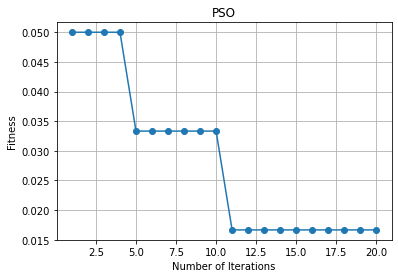

CPU times: user 16.3 s, sys: 12.5 s, total: 28.7 s
Wall time: 31.4 s


In [40]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 20  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [41]:
fmdl

{'param': array([[3.31640672, 0.0398359 ]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667]])}

In [42]:
parameter = fmdl['param'][0]

In [43]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [22]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = 3.31640672, gamma = 0.0398359))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.96
Mean F1 Measure :  0.9570286158168688
Mean Precision  :  0.9522222222222222
Mean Recall     :  0.9683333333333334
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9800000000000001
Mean F1 Measure :  0.979539641943734
Mean Precision  :  0.9777777777777779
Mean Recall     :  0.9833333333333332


In [48]:
from sklearn.metrics import classification_report
svc = SVC() 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.033333333333333326
Iteration: 9
Best (PSO): 0.033333333333333326
Iteration: 10
Best (PSO): 0.016666666666666607
Iteration: 11
Best (PSO): 0.016666666666666607
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607


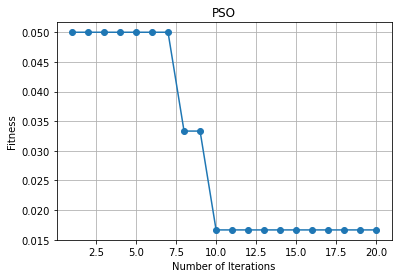

CPU times: user 19.3 s, sys: 17.3 s, total: 36.6 s
Wall time: 36.7 s


In [50]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 20  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [51]:
fmdl

{'param': array([[0.72792416, 0.21457594]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.03333333, 0.03333333, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667]])}

In [52]:
parameter = fmdl['param'][0]

In [53]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [54]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.04999999999999993
Iteration: 9
Best (PSO): 0.04999999999999993
Iteration: 10
Best (PSO): 0.04999999999999993
Iteration: 11
Best (PSO): 0.04999999999999993
Iteration: 12
Best (PSO): 0.04999999999999993
Iteration: 13
Best (PSO): 0.04999999999999993
Iteration: 14
Best (PSO): 0.04999999999999993
Iteration: 15
Best (PSO): 0.04999999999999993
Iteration: 16
Best (PSO): 0.04999999999999993
Iteration: 17
Best (PSO): 0.04999999999999993
Iteration: 18
Best (PSO): 0.04999999999999993
Iteration: 19
Best (PSO): 0.04999999999999993
Iteration: 20
Best (PSO): 0.04999999999999993


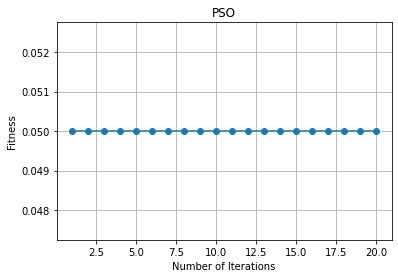

CPU times: user 26.3 s, sys: 23 s, total: 49.3 s
Wall time: 49.6 s


In [55]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 20  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [56]:
fmdl

{'param': array([[16.89353998,  2.44681093]]),
 'c': array([[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
         0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]])}

In [57]:
parameter = fmdl['param'][0]

In [58]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112


# ITERASI 40

Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.033333333333333326
Iteration: 7
Best (PSO): 0.033333333333333326
Iteration: 8
Best (PSO): 0.033333333333333326
Iteration: 9
Best (PSO): 0.033333333333333326
Iteration: 10
Best (PSO): 0.033333333333333326
Iteration: 11
Best (PSO): 0.033333333333333326
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607
Iteration: 21
Best (PSO): 0.016666666666666607
Iteration: 22
Best (PSO): 0

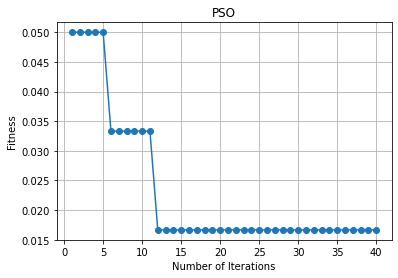

CPU times: user 25.8 s, sys: 22.5 s, total: 48.4 s
Wall time: 48.9 s


In [59]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 40  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [60]:
fmdl

{'param': array([[1.3050702 , 0.11588025]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667]])}

In [61]:
parameter = fmdl['param'][0]

In [62]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [63]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.4
Iteration: 2
Best (PSO): 0.20000000000000007
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.04999999999999993
Iteration: 9
Best (PSO): 0.04999999999999993
Iteration: 10
Best (PSO): 0.04999999999999993
Iteration: 11
Best (PSO): 0.04999999999999993
Iteration: 12
Best (PSO): 0.04999999999999993
Iteration: 13
Best (PSO): 0.04999999999999993
Iteration: 14
Best (PSO): 0.04999999999999993
Iteration: 15
Best (PSO): 0.04999999999999993
Iteration: 16
Best (PSO): 0.04999999999999993
Iteration: 17
Best (PSO): 0.04999999999999993
Iteration: 18
Best (PSO): 0.04999999999999993
Iteration: 19
Best (PSO): 0.04999999999999993
Iteration: 20
Best (PSO): 0.04999999999999993
Iteration: 21
Best (PSO): 0.04999999999999993
Iteration: 22
Best (PSO): 0.04999999999999993
Iteration: 23

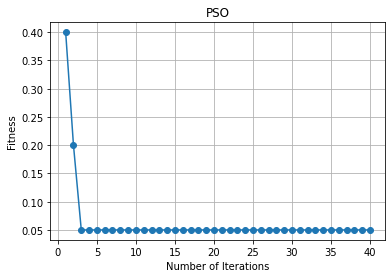

CPU times: user 39.4 s, sys: 34.6 s, total: 1min 14s
Wall time: 1min 14s


In [64]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 40  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [65]:
fmdl

{'param': array([[16.10471325,  2.04161796]]),
 'c': array([[0.4 , 0.2 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
         0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
         0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
         0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]])}

In [66]:
parameter = fmdl['param'][0]

In [67]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112


In [68]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.016666666666666607
Iteration: 8
Best (PSO): 0.016666666666666607
Iteration: 9
Best (PSO): 0.016666666666666607
Iteration: 10
Best (PSO): 0.016666666666666607
Iteration: 11
Best (PSO): 0.016666666666666607
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607
Iteration: 21
Best (PSO): 0.016666666666666607
Iteration: 22
Best (PSO): 0.

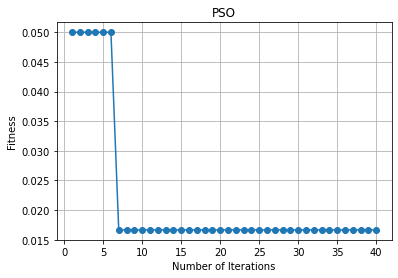

CPU times: user 51.5 s, sys: 45.9 s, total: 1min 37s
Wall time: 1min 38s


In [69]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 40  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [70]:
fmdl

{'param': array([[4.90340957, 0.02307606]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667]])}

In [71]:
parameter = fmdl['param'][0]

In [72]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [73]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.04999999999999993
Iteration: 9
Best (PSO): 0.04999999999999993
Iteration: 10
Best (PSO): 0.04999999999999993
Iteration: 11
Best (PSO): 0.04999999999999993
Iteration: 12
Best (PSO): 0.04999999999999993
Iteration: 13
Best (PSO): 0.04999999999999993
Iteration: 14
Best (PSO): 0.04999999999999993
Iteration: 15
Best (PSO): 0.04999999999999993
Iteration: 16
Best (PSO): 0.04999999999999993
Iteration: 17
Best (PSO): 0.04999999999999993
Iteration: 18
Best (PSO): 0.04999999999999993
Iteration: 19
Best (PSO): 0.04999999999999993
Iteration: 20
Best (PSO): 0.04999999999999993
Iteration: 21
Best (PSO): 0.04999999999999993
Iteration: 22
Best (PSO): 0.049999999999999

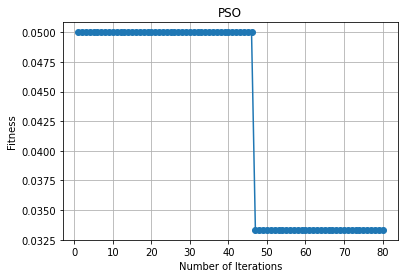

CPU times: user 52.3 s, sys: 45.7 s, total: 1min 38s
Wall time: 1min 38s


In [74]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 80  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [75]:
fmdl

{'param': array([[1.23719804, 0.80576434]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.033333

In [76]:
parameter = fmdl ['param'][0]

In [77]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9666666666666667
Mean F1 Measure :  0.9663299663299663
Mean Precision  :  0.9666666666666667
Mean Recall     :  0.9722222222222223


In [78]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.04999999999999993
Iteration: 9
Best (PSO): 0.04999999999999993
Iteration: 10
Best (PSO): 0.033333333333333326
Iteration: 11
Best (PSO): 0.033333333333333326
Iteration: 12
Best (PSO): 0.033333333333333326
Iteration: 13
Best (PSO): 0.033333333333333326
Iteration: 14
Best (PSO): 0.033333333333333326
Iteration: 15
Best (PSO): 0.033333333333333326
Iteration: 16
Best (PSO): 0.033333333333333326
Iteration: 17
Best (PSO): 0.033333333333333326
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607
Iteration: 21
Best (PSO): 0.016666666666666607
Iteration: 22
Best (PSO): 0.016

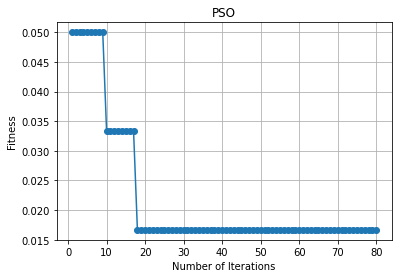

CPU times: user 1min 17s, sys: 1min 8s, total: 2min 25s
Wall time: 2min 26s


In [79]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 80  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [80]:
fmdl

{'param': array([[1.89168073, 0.0861926 ]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.016666

In [81]:
parameter = fmdl['param'][0]

In [82]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.016666666666666607
Iteration: 6
Best (PSO): 0.016666666666666607
Iteration: 7
Best (PSO): 0.016666666666666607
Iteration: 8
Best (PSO): 0.016666666666666607
Iteration: 9
Best (PSO): 0.016666666666666607
Iteration: 10
Best (PSO): 0.016666666666666607
Iteration: 11
Best (PSO): 0.016666666666666607
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607
Iteration: 21
Best (PSO): 0.016666666666666607
Iteration: 22
Best (PSO): 

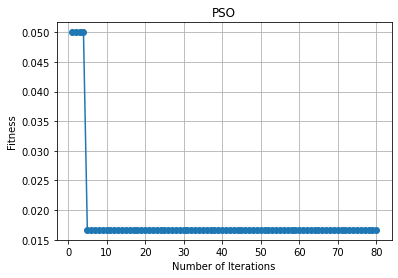

CPU times: user 1min 43s, sys: 1min 31s, total: 3min 14s
Wall time: 3min 15s


In [83]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 80  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [84]:
fmdl

{'param': array([[7.40512989, 0.0200813 ]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.016666

In [85]:
parameter = fmdl['param'][0]

In [86]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


# ITERASI 100

Iteration: 1
Best (PSO): 0.3833333333333333
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.016666666666666607
Iteration: 6
Best (PSO): 0.016666666666666607
Iteration: 7
Best (PSO): 0.016666666666666607
Iteration: 8
Best (PSO): 0.016666666666666607
Iteration: 9
Best (PSO): 0.016666666666666607
Iteration: 10
Best (PSO): 0.016666666666666607
Iteration: 11
Best (PSO): 0.016666666666666607
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607
Iteration: 21
Best (PSO): 0.016666666666666607
Iteration: 22
Best (PSO): 0

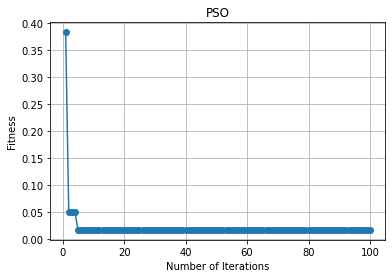

CPU times: user 1min 4s, sys: 56.5 s, total: 2min 1s
Wall time: 2min 2s


In [87]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 10    # number of particles
T    = 100  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [88]:
fmdl

{'param': array([[3.37291522, 0.05037725]]),
 'c': array([[0.38333333, 0.05      , 0.05      , 0.05      , 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.016666

In [89]:
parameter = fmdl['param'][0]

In [90]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [91]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.06666666666666676
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.04999999999999993
Iteration: 9
Best (PSO): 0.016666666666666607
Iteration: 10
Best (PSO): 0.016666666666666607
Iteration: 11
Best (PSO): 0.016666666666666607
Iteration: 12
Best (PSO): 0.016666666666666607
Iteration: 13
Best (PSO): 0.016666666666666607
Iteration: 14
Best (PSO): 0.016666666666666607
Iteration: 15
Best (PSO): 0.016666666666666607
Iteration: 16
Best (PSO): 0.016666666666666607
Iteration: 17
Best (PSO): 0.016666666666666607
Iteration: 18
Best (PSO): 0.016666666666666607
Iteration: 19
Best (PSO): 0.016666666666666607
Iteration: 20
Best (PSO): 0.016666666666666607
Iteration: 21
Best (PSO): 0.016666666666666607
Iteration: 22
Best (PSO): 0.01

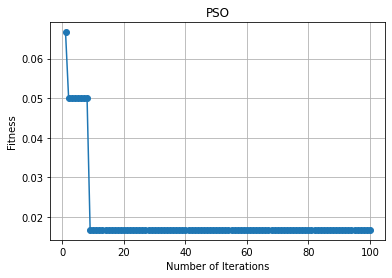

CPU times: user 1min 36s, sys: 1min 25s, total: 3min 2s
Wall time: 3min 2s


In [92]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 15    # number of particles
T    = 100  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [93]:
fmdl

{'param': array([[4.24317995, 0.02915265]]),
 'c': array([[0.06666667, 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.016666

In [94]:
parameter = fmdl ['param'][0]

In [95]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [96]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



Iteration: 1
Best (PSO): 0.04999999999999993
Iteration: 2
Best (PSO): 0.04999999999999993
Iteration: 3
Best (PSO): 0.04999999999999993
Iteration: 4
Best (PSO): 0.04999999999999993
Iteration: 5
Best (PSO): 0.04999999999999993
Iteration: 6
Best (PSO): 0.04999999999999993
Iteration: 7
Best (PSO): 0.04999999999999993
Iteration: 8
Best (PSO): 0.04999999999999993
Iteration: 9
Best (PSO): 0.04999999999999993
Iteration: 10
Best (PSO): 0.04999999999999993
Iteration: 11
Best (PSO): 0.04999999999999993
Iteration: 12
Best (PSO): 0.04999999999999993
Iteration: 13
Best (PSO): 0.04999999999999993
Iteration: 14
Best (PSO): 0.04999999999999993
Iteration: 15
Best (PSO): 0.04999999999999993
Iteration: 16
Best (PSO): 0.04999999999999993
Iteration: 17
Best (PSO): 0.04999999999999993
Iteration: 18
Best (PSO): 0.033333333333333326
Iteration: 19
Best (PSO): 0.033333333333333326
Iteration: 20
Best (PSO): 0.033333333333333326
Iteration: 21
Best (PSO): 0.033333333333333326
Iteration: 22
Best (PSO): 0.03333333333

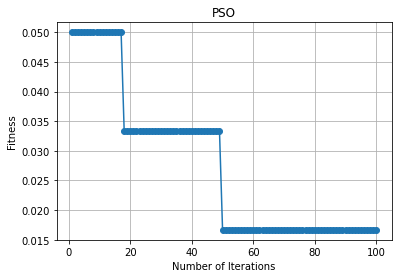

CPU times: user 2min 10s, sys: 1min 53s, total: 4min 4s
Wall time: 4min 5s


In [97]:
%%time
# setting parameter PSO
k    = 5     # k-value in KNN
N    = 20    # number of particles
T    = 100  # maximum number of iterations
w    = 0.9
c1   = 2
c2   = 2
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'w':w, 'c1':c1, 'c2':c2}

# perform feature selection
fmdl = jfs(X, y, opts)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0

fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

In [98]:
fmdl

{'param': array([[1.23985243e+01, 1.05337038e-02]]),
 'c': array([[0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.05      , 0.05      , 0.05      ,
         0.05      , 0.05      , 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
         0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 

In [99]:
parameter = fmdl['param'][0]

In [100]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = parameter[0] ,  gamma = parameter[1]))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [19]:
from sklearn.metrics import classification_report
svc = SVC(kernel = 'rbf', C = 1.23985243e+01, gamma = 1.05337038e-02) 
svc.fit(trainX,trainY)
svc_pred = svc.predict(testX)
print(classification_report(testY, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [17]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

cv = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
scoring     = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']

# Klasifikasi tanpa optimasi
mdl         = make_pipeline(DenseTfidfVectorizer(), SVC())
scores      = cross_validate(mdl, X, y, cv=cv, scoring=scoring)

# Klasifikasi dengan optimasi
mdl_PSO     = make_pipeline(DenseTfidfVectorizer(), SVC(kernel = 'rbf', C = 1.60996538e+01, gamma = 9.02347394e-03))
scores_PSO  = cross_validate(mdl_PSO, X, y, cv=cv, scoring=scoring)

print("Tanpa Optimasi")
print("Mean Accuracy   : ", np.mean(scores['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores['test_recall_macro']))

print("******************************************************")

print("Dengan Optimasi")
print("Mean Accuracy   : ", np.mean(scores_PSO['test_accuracy']))
print("Mean F1 Measure : ", np.mean(scores_PSO['test_f1_macro']))
print("Mean Precision  : ", np.mean(scores_PSO['test_precision_macro']))
print("Mean Recall     : ", np.mean(scores_PSO['test_recall_macro']))

Tanpa Optimasi
Mean Accuracy   :  0.9500000000000001
Mean F1 Measure :  0.9454313247416696
Mean Precision  :  0.938888888888889
Mean Recall     :  0.9611111111111112
******************************************************
Dengan Optimasi
Mean Accuracy   :  0.9833333333333334
Mean F1 Measure :  0.9829497016197783
Mean Precision  :  0.9814814814814815
Mean Recall     :  0.986111111111111


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
fold = { 'X': X, 'y': y}

In [24]:
svc = SVC()
X_train = tfidf.transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()
svc.fit(X_train,y_train)
svc_pred = svc.predict(X_test)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



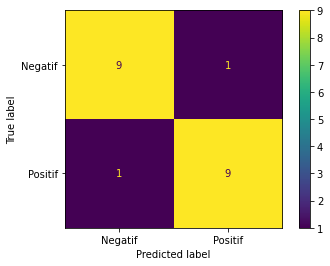

In [25]:
cm = confusion_matrix(y_test, svc_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Negatif", "Positif"])

cm_display.plot()
plt.show()

In [47]:
svc = SVC(kernel = 'rbf', C= 0.603016, gamma = 0.33697019)
X_train = tfidf.transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()
svc.fit(X_train,y_train)
svc_pred = svc.predict(X_test)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



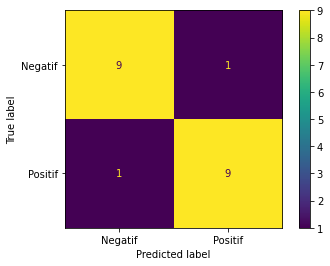

In [22]:
# cm = confusion_matrix(y_test, svc_pred)
# cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Negatif", "Positif"])

# cm_display.plot()
# plt.show()

Confusion Matrix SVM-PSO


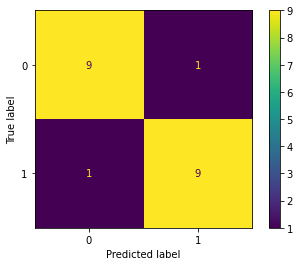

In [38]:
# print("Confusion Matrix SVM-PSO")
# conf_mat = confusion_matrix(y_test, svc_pred)

# cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_mat)

# cm_display.plot()
# plt.show()